## Synaptic Partner Prediction in FAFB

Analysis and visualization code to work with the synaptic partner predictions from Buhmann et al. 2019 and neuron
segmentation from Li et al. 2019.

November 2019, Stephan Gerhard <info@braincircuits.io>

### Prerequisites

* Download the SQLite database dump of all synaptic partner predictions and store it locally:
    * https://....
* The following Python packages are required:
    * [fafbseg-py](https://github.com/flyconnectome/fafbseg-py/)
    * [pymaid](https://github.com/schlegelp/pyMaid/)
    * [cloud-volume](https://github.com/seung-lab/cloud-volume/)
    * [pandas](https://pandas.pydata.org/)
    * [matplotlib](https://matplotlib.org/)
    * [networkx](https://networkx.github.io/)
    * [pyvis](https://pyvis.readthedocs.io/en/latest/index.html)

In [29]:
import sqlite3
import pandas as pd
import pymaid
import fafbseg
from cloudvolume import CloudVolume
from cloudvolume.datasource.precomputed.skeleton.sharded import ShardedPrecomputedSkeletonSource
import networkx as nx

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

%matplotlib notebook

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Source CATMAID instance and project to retrieve skeletons
source_catmaid_url = ''
source_catmaid_project_id = ''
source_catmaid_http_user = ''
source_catmaid_http_password = ''
source_catmaid_access_token = ''

# FAFB voxel resolution (in nm)
xres, yres, zres = 4,4,40

synaptic_predictions_dump_fname = ''

segmentation_server_url = "https://storage.googleapis.com/fafb-ffn1-20190805/segmentation"

In [3]:
if len(source_catmaid_url) > 0:
    source_catmaid = pymaid.CatmaidInstance(
                            source_catmaid_url,
                            source_catmaid_http_user,
                            source_catmaid_http_password,
                            source_catmaid_access_token)

In [4]:
# configuration for cloud volume with FAFB Google segmentation
CLOUDVOLUME_URL = 'precomputed://gs://fafb-ffn1-20190805/segmentation/'
CLOUDVOLUME_SKELETONS = 'skeletons_32nm_nothresh'

cv = CloudVolume(CLOUDVOLUME_URL, use_https=True)
cv.meta.info['skeletons'] = CLOUDVOLUME_SKELETONS
cv.skeleton.meta.refresh_info()
cv.skeleton = ShardedPrecomputedSkeletonSource(cv.skeleton.meta, cv.cache, cv.config)

In [5]:
# connect to the sqlite database holding the synaptic predictions
conn = sqlite3.connect(synaptic_predictions_dump_fname)
c = conn.cursor()

In [ ]:
# inspect the columns
c.execute('PRAGMA table_info(synlinks);').fetchall()

In [ ]:
# count the number of rows
c.execute('SELECT COUNT(*) FROM synlinks;').fetchall()

In [8]:
# fetch a bunch of links and convert them to a data frame
cols = ['ids', 'pre_x', 'pre_y', 'pre_z', 'post_x', 'post_y', 'post_z', 'scores',
        'segmentid_x', 'segmentid_y', 'max']
links = c.execute('select {} from synlinks limit 1000;'.format(','.join(cols))).fetchall()
df = pd.DataFrame.from_records(links, columns=cols)

<IPython.core.display.Javascript object>


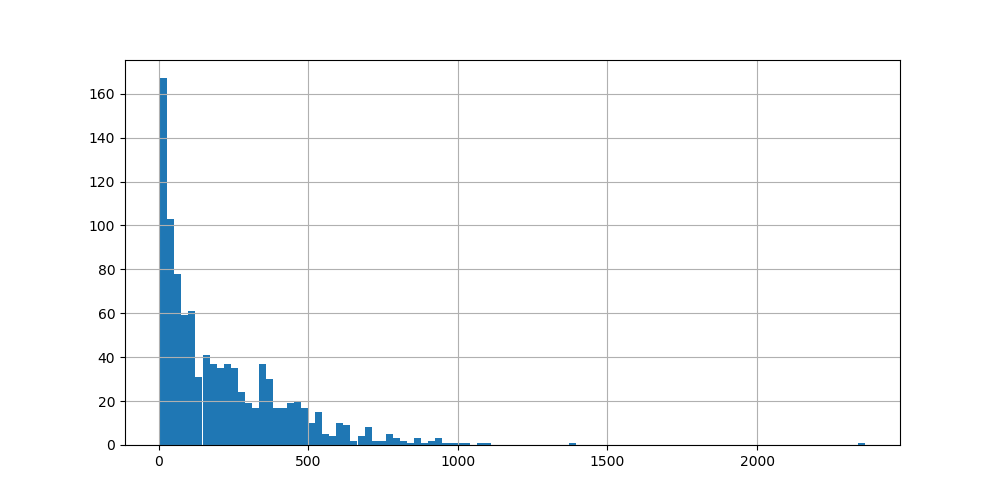

In [30]:
# show histogram of scores
plt.figure()
df['scores'].hist(bins=100)

<IPython.core.display.Javascript object>


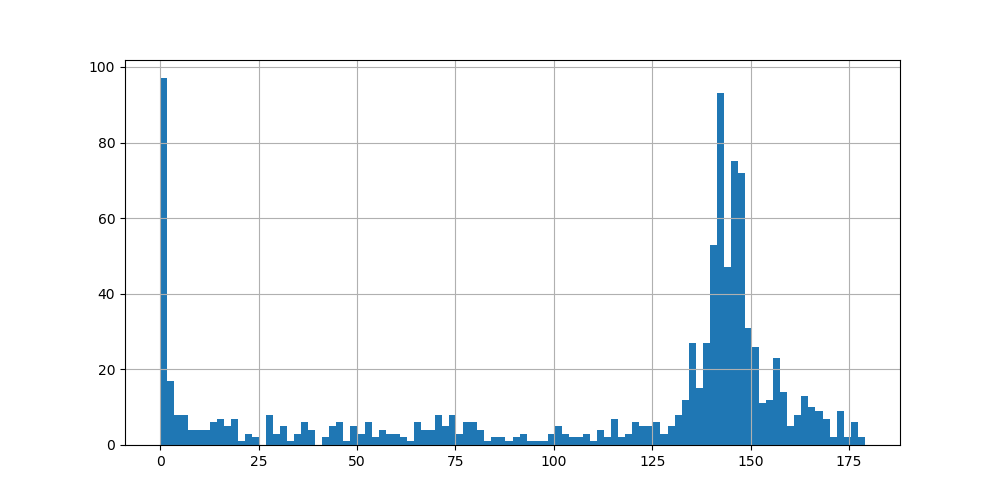

In [31]:
# show histogram of cleft max probability
plt.figure()
df['max'].hist(bins=100)

In [11]:
# retrieve all synaptic links for a supervoxel segmentID from the Google FFN segmentation
# http://fafb-ffn1.storage.googleapis.com/landing.html

# we browse the dataset in neuroglancer and pick a segment id
segment_id = 4613663523

In [12]:
# helper function to retrieve links as dataframe from sqlite
def get_links(segment_id, cursor, where='segmentid_x', table='synlinks'):
    cols = ['ids', 'pre_x', 'pre_y', 'pre_z', 'post_x', 'post_y', 
            'post_z', 'scores', 'segmentid_x', 'segmentid_y', 'max']
    cursor.execute('SELECT {} from {} where {} = {};'.format(','.join(cols), table, where, segment_id))
    pre_links = cursor.fetchall()
    return pd.DataFrame.from_records(pre_links, columns=cols)

In [13]:
# retrieve all presynaptic links
pre_links = get_links(segment_id, c, where='segmentid_x')
len(pre_links)

668

In [14]:
# retrieve all postsynaptic links
post_links = get_links(segment_id, c, where='segmentid_y')
len(post_links)

2814

In [15]:
# retrieve skeleton from google bucket via cloud-volume
skeleton = cv.skeleton.get(segment_id)

In [16]:
skel_x,skel_y,skel_z = skeleton.vertices[:,0], skeleton.vertices[:,1], skeleton.vertices[:,2]

In [17]:
# alternatively, we could also fetch a skeleton from a CATMAID instance with pymaid
"""
current_neuron = pymaid.get_neuron([segment_id], remote_instance=source_catmaid)
"""

'\ncurrent_neuron = pymaid.get_neuron([segment_id], remote_instance=source_catmaid)\n'

In [18]:
xspre = []; yspre = []; zspre = []
for k,v in pre_links.iterrows():
    xspre.append(v['pre_x']*xres)
    yspre.append(v['pre_y']*yres)
    zspre.append(v['pre_z']*zres)

In [19]:
xspost = []; yspost = []; zspost = []
for k,v in post_links.iterrows():
    xspost.append(v['post_x']*xres)
    yspost.append(v['post_y']*yres)
    zspost.append(v['post_z']*zres)

<IPython.core.display.Javascript object>


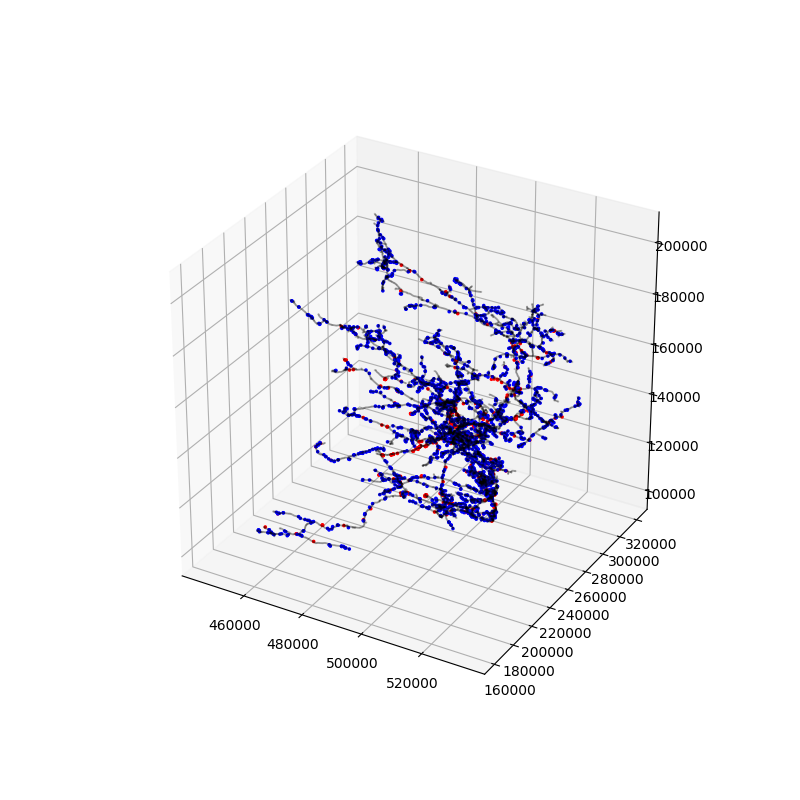

In [34]:
# plot skeleton with pre/post locations in 3d
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(skel_x, skel_y,skel_z, color='k', s=0.2, alpha=0.2)
ax.scatter(xspre, yspre, zspre, color='r', s=2.5, alpha=1.0)
ax.scatter(xspost, yspost, zspost, color='b', s=2.5, alpha=1.0)

In [21]:
# retrieve synaptic connectivity of this fragment/segment to other fragments/segments
all_postsynaptic_segments = set(pre_links['segmentid_y'])
all_presynaptic_segments = set(post_links['segmentid_x'])

In [22]:
# build a networkx graph of all segments where the edges reflect the synaptic count
g = nx.DiGraph()

for idx, r in pre_links.iterrows():
    from_id = int(r['segmentid_x'])
    to_id = int(r['segmentid_y'])
    if (from_id,to_id) in g.edges:
        g.edges[(from_id,to_id)]['count'] += 1
    else:
        g.add_edge(from_id, to_id, count= 1)

for idx, r in post_links.iterrows():
    from_id = int(r['segmentid_x'])
    to_id = int(r['segmentid_y'])
    if (from_id,to_id) in g.edges:
        g.edges[(from_id,to_id)]['count'] += 1
    else:
        g.add_edge(from_id, to_id, count= 1)


In [23]:
g.number_of_nodes()

1400

In [24]:
g.number_of_edges()

1419

In [25]:
# list edges sorted by synaptic count
edges_count = list(reversed(sorted(g.edges(data=True), key= lambda x: x[2]['count'])))
edges_count

[(0, 4613663523, {'count': 336}),
 (4613663523, 4613663523, {'count': 162}),
 (4613663523, 0, {'count': 99}),
 (1213951032, 4613663523, {'count': 48}),
 (2264439582, 4613663523, {'count': 43}),
 (4499848895, 4613663523, {'count': 28}),
 (4887524873, 4613663523, {'count': 25}),
 (6202879786, 4613663523, {'count': 23}),
 (4890722361, 4613663523, {'count': 20}),
 (2265126952, 4613663523, {'count': 20}),
 (3951482173, 4613663523, {'count': 18}),
 (4498564127, 4613663523, {'count': 18}),
 (4904766887, 4613663523, {'count': 16}),
 (6717873368, 4613663523, {'count': 15}),
 (3577845184, 4613663523, {'count': 15}),
 (3947000629, 4613663523, {'count': 14}),
 (2265766677, 4613663523, {'count': 14}),
 (5558583130, 4613663523, {'count': 14}),
 (5146594088, 4613663523, {'count': 14}),
 (2134028818, 4613663523, {'count': 13}),
 (4605342989, 4613663523, {'count': 12}),
 (3581782059, 4613663523, {'count': 12}),
 (2121773577, 4613663523, {'count': 11}),
 (7239307452, 4613663523, {'count': 11}),
 (567954

In [26]:
# we discard the links to empty space and self-loops, thus the next strongest links are segments with ids:
"""
(1213951032, 4613663523, {'count': 48}),
 (2264439582, 4613663523, {'count': 43}),
 (4499848895, 4613663523, {'count': 28}),
 (4887524873, 4613663523, {'count': 25}),
 (6202879786, 4613663523, {'count': 23}),
 (4890722361, 4613663523, {'count': 20}),
"""
partners = [k for k in edges_count if not k[0] == 0 and not k[1] == 0 and not k[0] == segment_id][:10]

In [27]:
# lets generate a list that we can use to select segments in neuroglancer
','.join(map(str,[k[0] for k in partners]))

'1213951032,2264439582,4499848895,4887524873,6202879786,4890722361,2265126952,3951482173,4498564127,4904766887'

[see meshes of segments with partners in neuroglancer](https://neuroglancer-demo.appspot.com/fafb.html#!%7B%22layers%22:%5B%7B%22source%22:%22precomputed://gs://neuroglancer-fafb-data/fafb_v14/fafb_v14_orig%22%2C%22type%22:%22image%22%2C%22name%22:%22fafb_v14%22%2C%22visible%22:false%7D%2C%7B%22source%22:%22precomputed://gs://neuroglancer-fafb-data/fafb_v14/fafb_v14_clahe%22%2C%22type%22:%22image%22%2C%22name%22:%22fafb_v14_clahe%22%7D%2C%7B%22type%22:%22segmentation%22%2C%22mesh%22:%22precomputed://gs://neuroglancer-fafb-data/elmr-data/FAFBNP.surf/mesh%22%2C%22segments%22:%5B%221%22%2C%2210%22%2C%2211%22%2C%2212%22%2C%2213%22%2C%2214%22%2C%2215%22%2C%2216%22%2C%2217%22%2C%2218%22%2C%2219%22%2C%222%22%2C%2220%22%2C%2221%22%2C%2222%22%2C%2223%22%2C%2224%22%2C%2225%22%2C%2226%22%2C%2227%22%2C%2228%22%2C%2229%22%2C%223%22%2C%2230%22%2C%2231%22%2C%2232%22%2C%2233%22%2C%2234%22%2C%2235%22%2C%2236%22%2C%2237%22%2C%2238%22%2C%2239%22%2C%224%22%2C%2240%22%2C%2241%22%2C%2242%22%2C%2243%22%2C%2244%22%2C%2245%22%2C%2246%22%2C%2247%22%2C%2248%22%2C%2249%22%2C%225%22%2C%2250%22%2C%2251%22%2C%2252%22%2C%2253%22%2C%2254%22%2C%2255%22%2C%2256%22%2C%2257%22%2C%2258%22%2C%2259%22%2C%226%22%2C%2260%22%2C%2261%22%2C%2262%22%2C%2263%22%2C%2264%22%2C%2265%22%2C%2266%22%2C%2267%22%2C%2268%22%2C%2269%22%2C%227%22%2C%2270%22%2C%2271%22%2C%2272%22%2C%2273%22%2C%2274%22%2C%2275%22%2C%228%22%2C%229%22%5D%2C%22skeletonRendering%22:%7B%22mode2d%22:%22lines_and_points%22%2C%22mode3d%22:%22lines%22%7D%2C%22name%22:%22neuropil-regions-surface%22%2C%22visible%22:false%7D%2C%7B%22type%22:%22mesh%22%2C%22source%22:%22vtk://https://storage.googleapis.com/neuroglancer-fafb-data/elmr-data/FAFB.surf.vtk.gz%22%2C%22vertexAttributeSources%22:%5B%5D%2C%22shader%22:%22void%20main%28%29%20%7BemitRGBA%28vec4%281.0%2C%200.0%2C%200.0%2C%200.5%29%29%3B%7D%22%2C%22name%22:%22neuropil-full-surface%22%2C%22visible%22:false%7D%2C%7B%22source%22:%22precomputed://gs://fafb-ffn1-20190805/segmentation%22%2C%22type%22:%22segmentation%22%2C%22segments%22:%5B%221213951032%22%2C%222264439582%22%2C%222265126952%22%2C%223951482173%22%2C%224498564127%22%2C%224499848895%22%2C%224613663523%22%2C%224887524873%22%2C%224890722361%22%2C%224904766887%22%2C%226202879786%22%5D%2C%22skeletonRendering%22:%7B%22mode2d%22:%22lines_and_points%22%2C%22mode3d%22:%22lines%22%7D%2C%22name%22:%22fafb-ffn1-20190805%22%7D%2C%7B%22source%22:%22precomputed://gs://fafb-ffn1-20190805/segmentation%22%2C%22type%22:%22segmentation%22%2C%22skeletons%22:%22precomputed://gs://fafb-ffn1-20190805/segmentation/skeletons_32nm%22%2C%22selectedAlpha%22:0%2C%22segments%22:%5B%224613663523%22%5D%2C%22skeletonRendering%22:%7B%22mode2d%22:%22lines_and_points%22%2C%22mode3d%22:%22lines%22%7D%2C%22name%22:%22skeletons_32nm%22%7D%2C%7B%22source%22:%22n5://gs://fafb-v14-synaptic-clefts-heinrich-et-al-2018-n5/synapses_dt_reblocked%22%2C%22type%22:%22image%22%2C%22opacity%22:0.73%2C%22shader%22:%22void%20main%28%29%20%7BemitRGBA%28vec4%280.0%2C0.0%2C1.0%2CtoNormalized%28getDataValue%28%29%29%29%29%3B%7D%22%2C%22name%22:%22clefts_Heinrich_etal%22%7D%5D%2C%22navigation%22:%7B%22pose%22:%7B%22position%22:%7B%22voxelSize%22:%5B4%2C4%2C40%5D%2C%22voxelCoordinates%22:%5B126620.234375%2C57437.2578125%2C3232.1064453125%5D%7D%7D%2C%22zoomFactor%22:35%7D%2C%22showAxisLines%22:false%2C%22perspectiveOrientation%22:%5B0.010064732283353806%2C0.054780226200819016%2C0.018741698935627937%2C-0.9982718229293823%5D%2C%22perspectiveZoom%22:2681.9999999999973%2C%22showSlices%22:false%2C%22selectedLayer%22:%7B%22layer%22:%22fafb-ffn1-20190805%22%2C%22visible%22:true%7D%2C%22layout%22:%223d%22%7D)

In [28]:
# NEXT: network visualization with pyvis